# gNMR Analysis

In [1]:
import os
import re
import glob
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
import scipy
import scipy
from scipy.optimize import curve_fit
import matplotlib 
from pylab import *
from scipy import odr as odr
sns.set()



## ODR-Fit

In [35]:
def odrFit(xValues, xErrors, yValues, yErrors, fitFunction, startParams):
    fitModel = odr.Model(fitFunction)
    data = odr.RealData(xValues, yValues, sx=xErrors, sy=yErrors)
    fitter = odr.ODR(data, fitModel, beta0=startParams)
    out = fitter.run()
    popt = out.beta
    perr = out.sd_beta

    ndof = xValues.size - startParams.size
    for index in range(0, popt.size):
        print('p' + str(index) + ' = ' + str(round(popt[index], 3)) 
              + ' +- ' + str(round(perr[index], 3)))
    print('Chi^2 = ' + str(round(out.sum_square, 3)))
    print('red. Chi^2 = ' + str(round(out.res_var, 3)))
    print()
    return popt,perr,out

# Aufgabe 4 - Spin-Gitter Relaxationszeit

In [21]:
#import data

df_etabak_4 = pd.read_csv("../data/etabak_auf_4.csv",sep = ";",decimal=",")
df_soe_4 = pd.read_csv("../data/schweres_oel_auf_4.csv",sep=";",decimal=",")


#add errors
df_etabak_4["tau_err"] = 0.005
df_etabak_4["u_err"] = df_etabak_4["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

df_soe_4["tau_err"] = 0.005
df_soe_4["u_err"] = df_soe_4["delta_v"].apply(lambda x: 0.01 if x >= 1 else 0.005)

In [23]:
df_etabak_4

,tau,delta_v,csv_datei,tau_err,u_err
0,0.005,3.5250,31,0.005,0.010
1,0.010,3.1125,32,0.005,0.010
2,0.015,2.7625,33,0.005,0.010
3,0.020,2.3750,34,0.005,0.010
4,0.025,2.0375,35,0.005,0.010
5,0.030,1.7375,36,0.005,0.010
6,0.035,1.4680,37,0.005,0.010
7,0.040,1.1812,38,0.005,0.010
8,0.045,0.9060,39,0.005,0.005
9,0.050,0.6430,40,0.005,0.005


p0 = 3.875 +- 0.023
p1 = 0.09 +- 0.002
Chi^2 = 57.204
red. Chi^2 = 2.86

Beta: [3.87469739 0.08996033]
Beta Std Error: [0.02294418 0.0023322 ]
Beta Covariance: [[1.84055536e-04 1.27123830e-05]
 [1.27123830e-05 1.90166704e-06]]
Residual Variance: 2.860198142101049
Inverse Condition #: 0.13069635045077874
Reason(s) for Halting:
  Sum of squares convergence


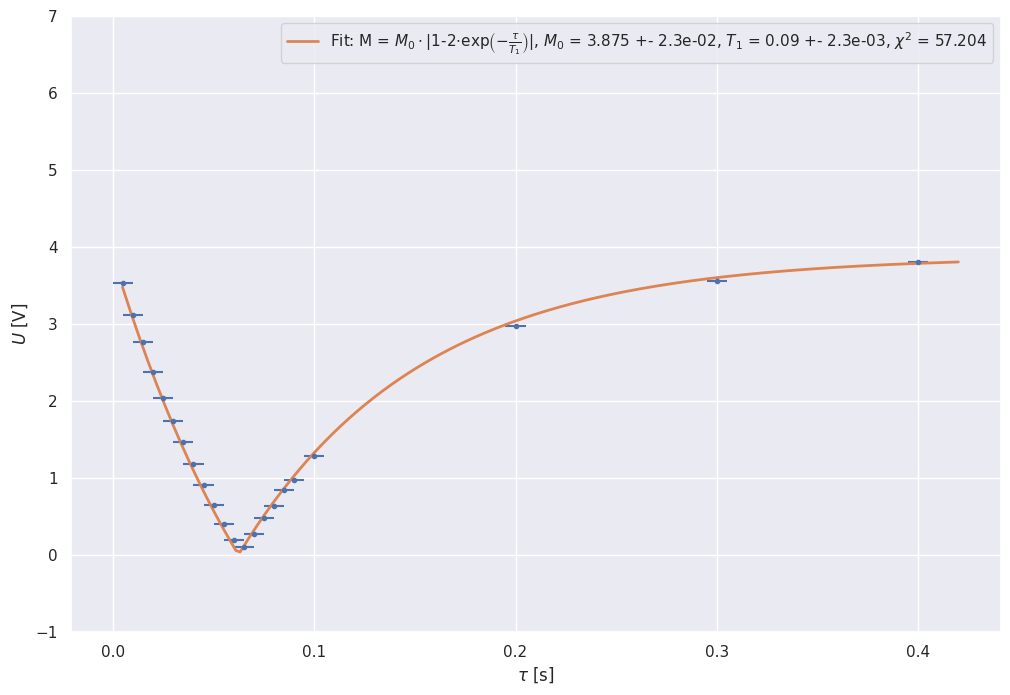

In [39]:


def fitFunc(params, x):
    m0, T1 = params
    return (m0*np.abs(1-2*(np.exp(-x/T1))))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_etabak_4["tau"].to_numpy()
xErr = df_etabak_4["tau_err"].to_numpy()
yData = df_etabak_4["delta_v"].to_numpy()
yErr = df_etabak_4["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.065])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$|1-2$\cdot$exp$\left(-\frac{\tau}{T_{1}}\right)$|, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{1}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_4_etabak.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

p0 = 3.955 +- 0.014
p1 = 0.042 +- 0.002
Chi^2 = 47.773
red. Chi^2 = 3.981

Beta: [3.95487585 0.04218925]
Beta Std Error: [0.01404749 0.00223004]
Beta Covariance: [[4.95670954e-05 3.06944622e-06]
 [3.06944622e-06 1.24917005e-06]]
Residual Variance: 3.9811092023868864
Inverse Condition #: 0.03868482306115836
Reason(s) for Halting:
  Sum of squares convergence


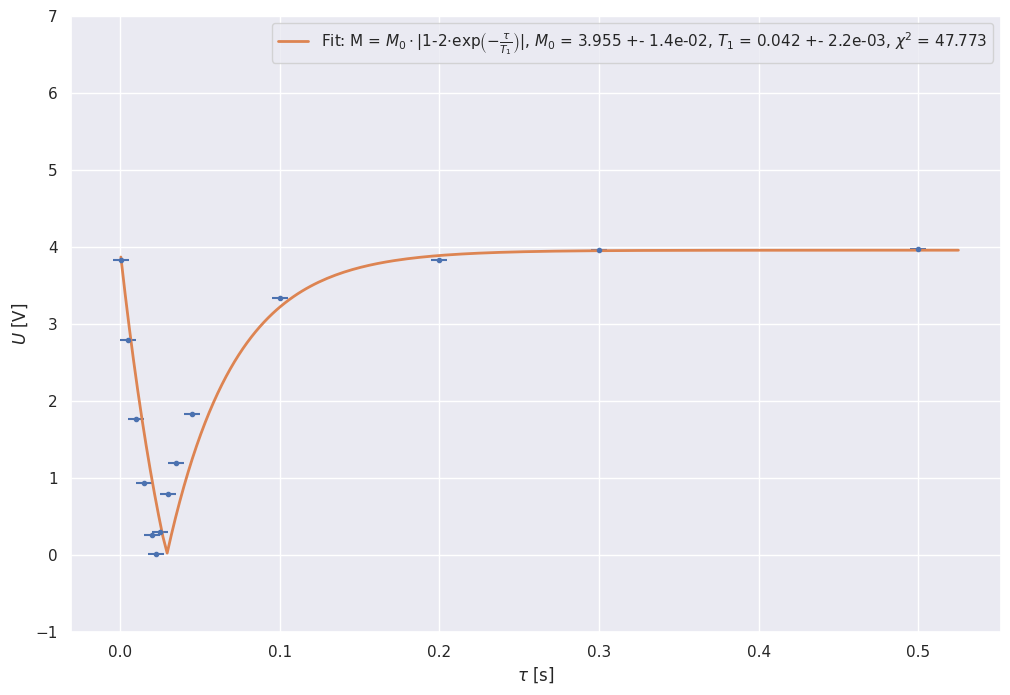

In [41]:


def fitFunc(params, x):
    m0, T1 = params
    return (m0*np.abs(1-2*(np.exp(-x/T1))))

# Define the numpy arrays with the data points and the corresponding errors:

xData = df_soe_4["tau"].to_numpy()
xErr = df_soe_4["tau_err"].to_numpy()
yData = df_soe_4["delta_v"].to_numpy()
yErr = df_soe_4["u_err"].to_numpy()

# Set the start values for the parameters of our function, and call the fit routine. 
# Remember: all arguments of our fitFunc are numpy arrays:

startParameters = np.array([yData[0], 0.025])
popt, perr, fitResult = odrFit(xData, xErr, yData, yErr, fitFunc, startParameters)
#print(popt)
#print(perr)
# Have a look to the fit result:
fitResult.pprint()

# Let's make a plot of the result:

x_fit = np.linspace(0.95*min(xData), 1.05*max(xData), 200)
fit = fitFunc(popt, x_fit)

# calculate the residuals in y direction
residuals = fitResult.eps / yErr

error_fmt = " +- {:.1e}"

fig1 = plt.figure(figsize=(12,8))
plt.errorbar(xData, yData, xerr = xErr, yerr = yErr, fmt = '.')
plt.plot(x_fit, fit, lw=2, label=
         r'Fit: M = $M_{0}\cdot$|1-2$\cdot$exp$\left(-\frac{\tau}{T_{1}}\right)$|, $M_{0}$ = ' + str(round(popt[0], 3)) + error_fmt.format(perr[0]) 
         + r', ${T_{1}}$ = ' + str(round(popt[1], 3)) + error_fmt.format(perr[1]) 
         + ', $\chi^2$ = ' + str(round(fitResult.sum_square, 3)))
plt.xlabel(r"$\tau$ [s]")
plt.ylabel(r"$U$ [V]")
plt.ylim(-1,7)
plt.legend()
#plt.title('Lebensdauer von Myonen')

# fig2 = plt.figure(figsize=(12,2.5))
# plot(xData, residuals,'or')
# plt.xlabel(r"Zeitdelay [$\mu$s]")
# plt.ylabel('Residuals')
# plt.grid()
plt.savefig("../images/aufgabe_4_soel.jpg")
plt.show()

# The quite large values for Chi^2 and Chi^2/ndof show that this is not a good fit, what is aslo
# clearly visible in the plot. The statistical errors are not sufficient to explain the spread
# of the data points around the best curve.

## Aufgabe 5 - Spin-Spin-Relaxationszeit mit Spin-Echo